# MeLi Data Challenge 2021
O objetivo deste desafio é prever quantos dias (de 1 a 30) uma certa quantidade de uma unidade de estoque (sku) irá levar para se esgotar. Para isso temos os dados de treinamento (train_data.parquet) e os dados dos itens (items_static_metadata_full.jl).
Neste notebook iremos realizar primeiramente uma análise exploratória sobre os dados fornecidos e então, utilizaremos um modelo de aprendizado de máquina para classificação em 30 classes de cada par (sku, dias) do conjunto de teste (test_data.csv).

In [1]:
import pandas as pd
from unidecode import unidecode
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

## Leitura dos dados
Os dados de treino estão em um arquivo do tipo `parquet` e tendem a utilizar bastante memória durante a leitura, além de ser um conjundo grande. Portanto, após a leitura utilizaremos algumas técnicas para reduzir a quantidade de memória utilizada pelos `DataFrames`.
Temos disponível também um arquivo com as informações dos itens. Após a leitura deste iremos unir as informações dos dois arquivos em um único `DataFrame` para tratamento.

In [2]:
train_data = pd.read_parquet('data/train_data.parquet')
train_data.head()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active
0,464801,2021-02-01,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
1,464801,2021-02-02,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
2,464801,2021-02-03,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
3,464801,2021-02-04,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
4,464801,2021-02-05,1,156.78,REA,classic,fulfillment,free_shipping,1440.0


Após a leitura, normalmente observamos um elevado uso de RAM, vamos analisar este uso no DataFrame lido e otimizá-lo seguindo o [guia para datasets grandes](https://pandas.pydata.org/docs/user_guide/scale.html).

In [3]:
train_data.dtypes

sku                         int64
date                       object
sold_quantity               int64
current_price             float64
currency                   object
listing_type               object
shipping_logistic_type     object
shipping_payment           object
minutes_active            float64
dtype: object

In [4]:
train_data.memory_usage(deep=True)

Index                            128
sku                        301282232
date                      2523238693
sold_quantity              301282232
current_price              301282232
currency                  2259616740
listing_type              2410257856
shipping_logistic_type    2557613835
shipping_payment          2636219530
minutes_active             301282232
dtype: int64

In [5]:
mem_before = train_data.memory_usage(deep=True).sum()
mem_before

13592075710

In [6]:
train_data['date'] = pd.to_datetime(train_data['date'])
train_data['currency'] = train_data['currency'].astype('category')
train_data['listing_type'] = train_data['listing_type'].astype('category')
train_data['shipping_logistic_type'] = train_data['shipping_logistic_type'].astype('category')
train_data['shipping_payment'] = train_data['shipping_payment'].astype('category')

In [7]:
train_data.dtypes

sku                                int64
date                      datetime64[ns]
sold_quantity                      int64
current_price                    float64
currency                        category
listing_type                    category
shipping_logistic_type          category
shipping_payment                category
minutes_active                   float64
dtype: object

In [8]:
train_data.memory_usage(deep=True)

Index                           128
sku                       301282232
date                      301282232
sold_quantity             301282232
current_price             301282232
currency                   37660691
listing_type               37660515
shipping_logistic_type     37660590
shipping_payment           37660527
minutes_active            301282232
dtype: int64

In [9]:
mem_after = train_data.memory_usage(deep=True).sum()
mem_after / mem_before

0.12191321225358301

O arquivo de dados de treinamento não apresenta entradas nulas.

In [10]:
train_data.isna().sum()

sku                       0
date                      0
sold_quantity             0
current_price             0
currency                  0
listing_type              0
shipping_logistic_type    0
shipping_payment          0
minutes_active            0
dtype: int64

Após a redução para 12% do tamanho original, vamos ler o segundo arquivo de dados e aplicar algumas das mesmas transformações, para então juntá-los em um único `DataFrame` para melhor análise.

In [11]:
items_data = pd.read_json('data/items_static_metadata_full.jl', lines=True)
items_data

,item_domain_id,item_id,item_title,site_id,sku,product_id,product_family_id
0,MLB-SNEAKERS,492155,Tênis Masculino Olympikus Cyber Barato Promoçao,MLB,0,None,MLB15832732
1,MLB-SURFBOARD_RACKS,300279,Suporte Rack Prancha Parede C/ Regulagem Horiz...,MLB,1,None,None
2,MLM-NECKLACES,69847,5 Collares Plateados Dama Gargantilla Choker -...,MLM,2,None,None
3,MLM-RINGS,298603,Lindo Anillo De Bella Crepusculo Twilight Prom...,MLM,3,None,None
4,MLB-WEBCAMS,345949,Webcam Com Microfone Hd 720p Knup Youtube Pc V...,MLB,4,None,None
...,...,...,...,...,...,...,...
660911,MLB-CELLPHONE_PARTS,320792,2 Parafuso Pentalobe Torx iPhone 5 5c 5s 6 6s ...,MLB,660911,None,None
660912,MLM-AUTOMOTIVE_EMBLEMS,90441,Emblema Circular Wolfsburg Edition 5cm,MLM,660912,None,None
660913,MLB-SOFA_AND_FUTON_COVERS,202580,Kit Capa De Sofá Coladinha Jogo 2e3 Lugares Ma...,MLB,660913,None,None
660914,MLB-SNEAKERS,490874,Calçado Sapatênis Clássico Baltic 234 Ollie,MLB,660914,None,None


In [12]:
items_data.dtypes

item_domain_id       object
item_id               int64
item_title           object
site_id              object
sku                   int64
product_id           object
product_family_id    object
dtype: object

In [13]:
items_data['item_domain_id'] = items_data['item_domain_id'].astype('category')
items_data['item_title'] = items_data['item_title'].apply(unidecode).astype('category')
items_data['site_id'] = items_data['site_id'].astype('category')
items_data['product_id'] = items_data['product_id'].astype('category')
items_data['product_family_id'] = items_data['product_family_id'].astype('category')

Vemos três itens sem `item_domain_id`, há a possibilidade de conseguirmos inferir qual deve ser este domain.

In [14]:
items_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660916 entries, 0 to 660915
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   item_domain_id     660913 non-null  category
 1   item_id            660916 non-null  int64   
 2   item_title         660916 non-null  category
 3   site_id            660916 non-null  category
 4   sku                660916 non-null  int64   
 5   product_id         29668 non-null   category
 6   product_family_id  83184 non-null   category
dtypes: category(5), int64(2)
memory usage: 39.0 MB


Estes itens possuem `product_family_id`, podemos utilizar isto para obter mais informações sobre seu possível `item_domain_id`

In [15]:
items_data[items_data['item_domain_id'].isna()]

,item_domain_id,item_id,item_title,site_id,sku,product_id,product_family_id
454273,NaN,245417,Fone De Ouvido Multilaser Tws Ph326 Airbud Sem...,MLB,454273,NaN,MLB16117735
459892,NaN,283198,Headset Gamer Multilaser P2 Ph123 Preto E Verde,MLB,459892,NaN,MLB16158968
553503,NaN,114028,Prancha De Cabelo Taiff Elegance Frizz Ceramic...,MLB,553503,NaN,MLB17821818


Vemos que o item de id `114028` deve ser do domínio `MLB-HAIR_STRAIGHTENERS`, assim como o item `245417` deve ser do domínio `MLB-HEADPHONES`. O item `283198` se trata de um Headset, portanto também deve ser do domínio `MLB-HEADPHONES`.

In [16]:
items_data[items_data['product_family_id'].isin(['MLB16117735', 'MLB16158968', 'MLB17821818'])]

,item_domain_id,item_id,item_title,site_id,sku,product_id,product_family_id
409433,MLB-HAIR_STRAIGHTENERS,465687,Prancha Chapa Taiff Frizz 230oc Cria Volume Pa...,MLB,409433,NaN,MLB17821818
454273,NaN,245417,Fone De Ouvido Multilaser Tws Ph326 Airbud Sem...,MLB,454273,NaN,MLB16117735
459892,NaN,283198,Headset Gamer Multilaser P2 Ph123 Preto E Verde,MLB,459892,NaN,MLB16158968
553503,NaN,114028,Prancha De Cabelo Taiff Elegance Frizz Ceramic...,MLB,553503,NaN,MLB17821818
592619,MLB-HEADPHONES,374028,Fone De Ouvido Multilaser Tws Airbuds Ph326 Br...,MLB,592619,NaN,MLB16117735


In [17]:
items_data.loc[[454273, 459892, 553503], 'item_domain_id'] = ['MLB-HEADPHONES', 'MLB-HEADPHONES', 'MLB-HAIR_STRAIGHTENERS']
items_data['item_domain_id'].isna().sum()

0

In [18]:
df = train_data.merge(items_data, how='left', on='sku')
df.shape

(37660279, 15)

In [21]:
del train_data, items_data, mem_before, mem_after
import gc
gc.collect()

175

## Análise Exploratória - Primeira Fase
Agora que temos os dados carregados em memória e tratados para menor consumo de RAM, vamos iniciar a análise exploratória.
Neste _notebook_ faremos a análise de cada variável de forma independente (ou com relação apenas ao tempo) e depois aprofundaremos as análises para relações entre duas ou mais variáveis.
Esta análise terá por objetivo entender o preenchimento dos dados e tirar insights para ajudar na futura modelagem do problema.

In [19]:
df.head()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,item_domain_id,item_id,item_title,site_id,product_id,product_family_id
0,464801,2021-02-01,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,344151,Inalador E Nebulizador Infantil Nebdog Superfl...,MLB,MLB9838512,MLB9838510
1,464801,2021-02-02,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,344151,Inalador E Nebulizador Infantil Nebdog Superfl...,MLB,MLB9838512,MLB9838510
2,464801,2021-02-03,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,344151,Inalador E Nebulizador Infantil Nebdog Superfl...,MLB,MLB9838512,MLB9838510
3,464801,2021-02-04,0,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,344151,Inalador E Nebulizador Infantil Nebdog Superfl...,MLB,MLB9838512,MLB9838510
4,464801,2021-02-05,1,156.78,REA,classic,fulfillment,free_shipping,1440.0,MLB-NEBULIZERS,344151,Inalador E Nebulizador Infantil Nebdog Superfl...,MLB,MLB9838512,MLB9838510


In [20]:
df.dtypes

sku                                int64
date                      datetime64[ns]
sold_quantity                      int64
current_price                    float64
currency                        category
listing_type                    category
shipping_logistic_type          category
shipping_payment                category
minutes_active                   float64
item_domain_id                  category
item_id                            int64
item_title                      category
site_id                         category
product_id                      category
product_family_id               category
dtype: object

In [21]:
pd.concat([df.isna().sum(), df.isna().sum() / df.count()], axis=1).rename(columns={0: 'NAs', 1: '% of NAs'})

,NAs,% of NAs
sku,0,0.000000
date,0,0.000000
sold_quantity,0,0.000000
current_price,0,0.000000
currency,0,0.000000
listing_type,0,0.000000
shipping_logistic_type,0,0.000000
shipping_payment,0,0.000000
minutes_active,0,0.000000
item_domain_id,0,0.000000


### SKU - `int64`
É uma coluna de id, vamos apenas validar que segue todas as propriedades

In [22]:
print('count:', df['sku'].count())
print('min:', df['sku'].min())
print('max:', df['sku'].max())
print('uniques:', df['sku'].nunique())

count: 37660279
min: 0
max: 660915
uniques: 660916


### Date - `datetime64[ns]`

Coluna de data, aqui temos os dois meses usados para treino: Fevereiro e Março

In [23]:
df['date'].isna().sum()

0

Temos mais registros referentes ao mês de Março

<AxesSubplot:>

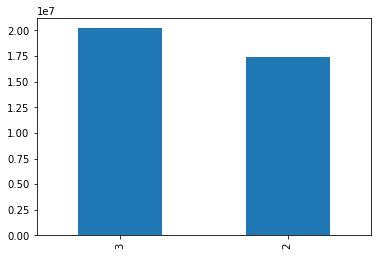

In [24]:
df['date'].dt.month.value_counts().plot.bar()

Vemos uma queda brusca na quantidade de registros nos dias 29, 30 e 31, isso se dá por conta de um dos meses ser Fevereiro, o qual possui apenas 28 dias.
Olhando para os dias 1-28, vemos algo que parece uma tendência de subida na quantidade de registros. O que isto quer dizer?

<AxesSubplot:>

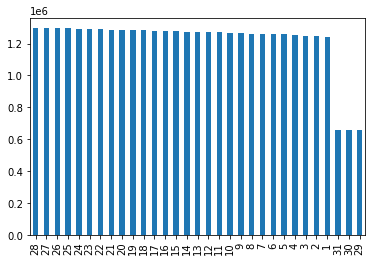

In [25]:
df['date'].dt.day.value_counts().plot.bar()

Vamos comparar a quantidade de registros entre os meses desconsiderando os dias 29, 30 e 31 de março. Ainda temos mais registros para Março.

<AxesSubplot:>

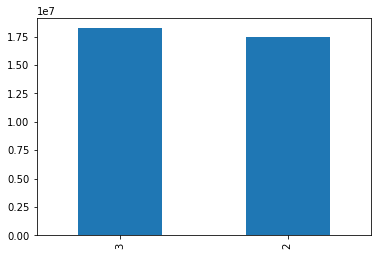

In [26]:
filter_last_days = df['date'].dt.day < 29
df[filter_last_days]['date'].dt.month.value_counts().plot.bar()

Olhando para cada semana do ano, a leve tendência de mais registros conforme o tempo passa continua.

<ipython-input-27-59ca919a3701>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df[filter_last_days]['date'].dt.week.value_counts().plot.bar()


<AxesSubplot:>

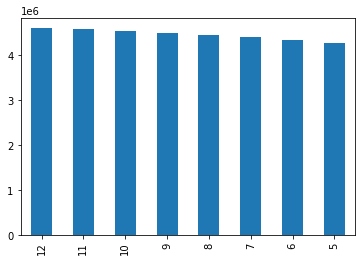

In [27]:
df[filter_last_days]['date'].dt.week.value_counts().plot.bar()

A distribuição de datas ao longo da semana é uniforme. Não apresenta mais registros em certos dias da semana.

<AxesSubplot:>

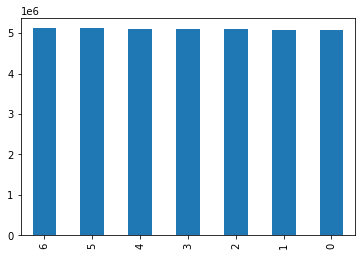

In [28]:
df[filter_last_days]['date'].dt.weekday.value_counts().plot.bar()

### Sold Quantity - `int64`

Quantidade de unidades vendidas no dia de referência

Quase 3/4 dos registros apontam para nenhuma venda do item no dia de referência.

In [29]:
print('mean:', df['sold_quantity'].mean())
print('median:', df['sold_quantity'].median())
print('min:', df['sold_quantity'].min())
print('max:', df['sold_quantity'].max())
(df['sold_quantity'] == 0).sum() / df['sold_quantity'].count()

mean: 0.990093355389109
median: 0.0
min: 0
max: 6951


0.7316311437841445

In [30]:
df['sold_quantity'].value_counts()[:10]

0    27553433
1     4970987
2     2019425
3      971857
4      559814
5      352729
6      242989
7      167786
8      125495
9       93633
Name: sold_quantity, dtype: int64

Apesar da maioria dos registros ser de nenhuma venda, existem registros com muitas vendas em cada dia, vale observar a quais itens ou produtos estas vendas se referem.

<AxesSubplot:>

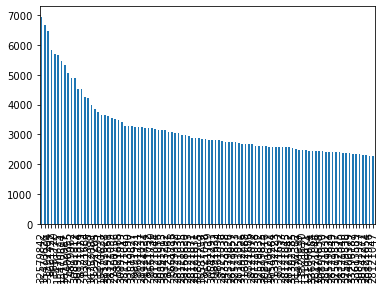

In [31]:
df['sold_quantity'].nlargest(100).plot.bar()

Vemos um efeito sazonal nas vendas, ao que parece referente aos dias da semana, vamos tentar observar outros efeitos sazonais

<AxesSubplot:xlabel='date'>

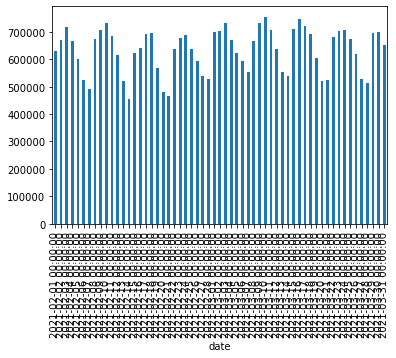

In [32]:
df.groupby('date').sum()['sold_quantity'].plot.bar()

<AxesSubplot:xlabel='date'>

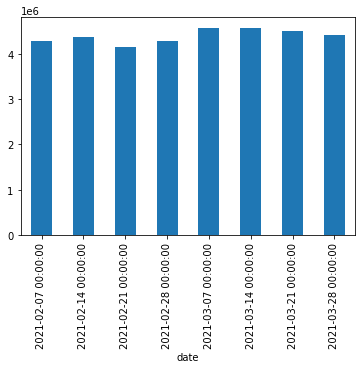

In [33]:
df[filter_last_days].groupby(pd.Grouper(key='date', freq='W')).sum()['sold_quantity'].plot.bar()

Vemos menos vendas durante os finais de semana, com o pico na quarta-feira

<AxesSubplot:xlabel='date'>

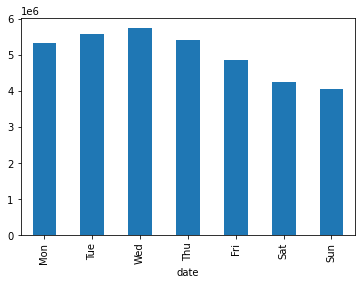

In [34]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df[filter_last_days].groupby(df[filter_last_days]['date'].dt.weekday).sum().rename(index=lambda i: days[i])['sold_quantity'].plot.bar()

### Currency - `category`

Em qual moeda está o preço do anúncio

In [35]:
df['currency'].value_counts()

REA    19229164
MEX    15157756
ARG     3273179
DOL         180
Name: currency, dtype: int64

### Current Price - `float64`

Preço do anúncio no dia de referência na moeda local do país. Vemos que em cada moeda os preços tem alguns valores extremos que parecem ser outliers.

In [36]:
for c in df['currency'].unique():
    print('currency:', c)
    filter_currency = df['currency'] == c
    price = df[filter_currency]['current_price']
    print('min:', price.min())
    print('max:', price.max())
    print('mean:', price.mean())
    print('median:', price.median())
    print('-'*30)


currency: REA
min: 0.87
max: 999999999.0
mean: 317.80997900783524
median: 54.3
------------------------------
currency: MEX
min: 1.0
max: 999999999.0
mean: 4534.47703738112
median: 229.0
------------------------------
currency: DOL
min: 3.2
max: 687.14
mean: 17.478833333333423
median: 4.8
------------------------------
currency: ARG
min: 8.0
max: 29965437.0
mean: 4262.202017522039
median: 1599.0
------------------------------


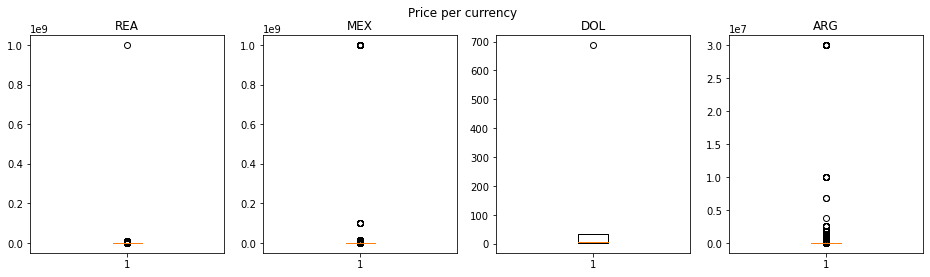

In [37]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
i = 0
for c in df['currency'].unique():
    axs[i].set_title(c)
    axs[i].boxplot(df[df['currency'] == c]['current_price'])
    i += 1
fig.suptitle('Price per currency')
plt.show()

Podemos ver uma oscilação no preço mediano ao longo dos dias

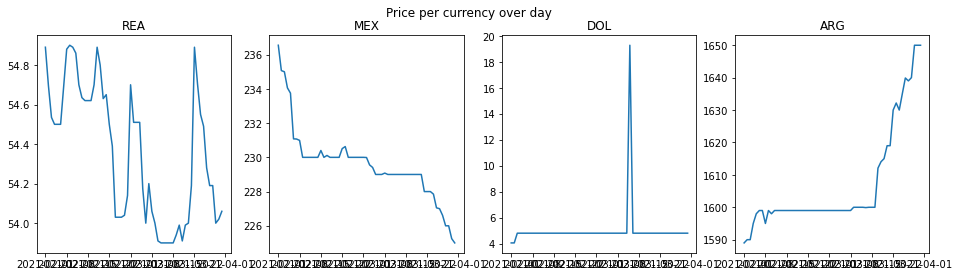

In [38]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
i = 0
for c in df['currency'].unique():
    filter_currency = df['currency'] == c
    axs[i].set_title(c)
    prices = df[filter_currency].groupby('date').median()['current_price'].sort_index()
    axs[i].plot(prices.index, prices.values)
    i += 1
fig.suptitle('Price per currency over day')
plt.show()

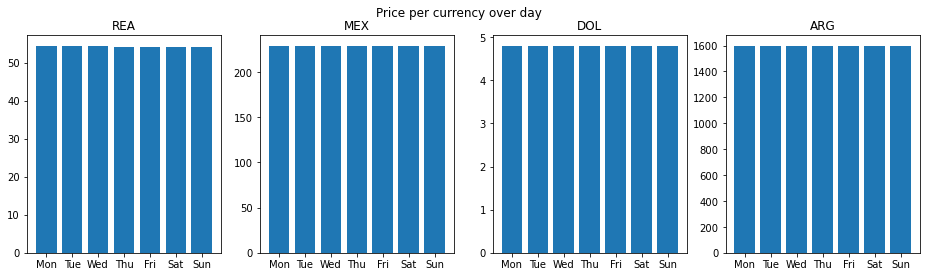

In [39]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
i = 0
for c in df['currency'].unique():
    filter_currency = df['currency'] == c
    axs[i].set_title(c)
    prices = df[filter_currency].groupby(df['date'].dt.weekday).median()['current_price'].sort_index()
    axs[i].bar(days, height=prices.values)
    i += 1
fig.suptitle('Price per currency over day')
plt.show()

### Listing Type - `category`

Qual o tipo do anúncio entre `classic` e `premium`. Observamos uma distribuição uniforme entre os registros

In [40]:
df['listing_type'].value_counts()

classic    18860849
premium    18799430
Name: listing_type, dtype: int64

In [41]:
df['listing_type'].value_counts() / df['listing_type'].count()

classic    0.500815
premium    0.499185
Name: listing_type, dtype: float64

### Shipping Logistic Type - `category`

Tipo do frete entre `fulfillment`, `drop_off` e `cross_docking`. Vemos que o tipo `fulfillment` é de longe o mais comum.

In [42]:
df['shipping_logistic_type'].value_counts()

fulfillment      32390495
drop_off          2764941
cross_docking     2504843
Name: shipping_logistic_type, dtype: int64

In [43]:
df['shipping_logistic_type'].value_counts() / df['shipping_logistic_type'].count()

fulfillment      0.860071
drop_off         0.073418
cross_docking    0.066512
Name: shipping_logistic_type, dtype: float64

### Shipping Payment - `category`
Comprador paga pelo frete? Caso `paid_shipping`, o consumidor paga o frete, caso seja `free_shipping` o frete é grátis para o consumidor.

O frete pago pelo consumidor é mais comum, sendo cerca de 2/3 dos registros

In [44]:
df['shipping_payment'].value_counts()

paid_shipping    24947755
free_shipping    12712524
Name: shipping_payment, dtype: int64

In [45]:
df['shipping_payment'].value_counts() / df['shipping_payment'].count()

paid_shipping    0.662442
free_shipping    0.337558
Name: shipping_payment, dtype: float64

### Minutes Active - `float64`
Quantos minutos o anúncio ficou ativo no dia. Temos que a maioria (70%) dos anúncios fica ativo durante o dia inteiro, seguido pelos anúncios que não estão ativos em nenhum momento do dia (25%).

In [46]:
print('mean:', df['minutes_active'].mean())
print('median:', df['minutes_active'].median())
print('min:', df['minutes_active'].min())
print('max:', df['minutes_active'].max())
print('0 minutes:', (df['minutes_active'] == 0).sum() / df['minutes_active'].count())
print('all day:', (df['minutes_active'] == 1440).sum() / df['minutes_active'].count())

mean: 1043.414678264399
median: 1440.0
min: 0.0
max: 1440.0
0 minutes: 0.25395767779627976
all day: 0.6989530003216387


Vamos observar removendo as observações de 0 minutos e 1440 minutos para poder enxergar variações entre estes extremos

<AxesSubplot:ylabel='Frequency'>

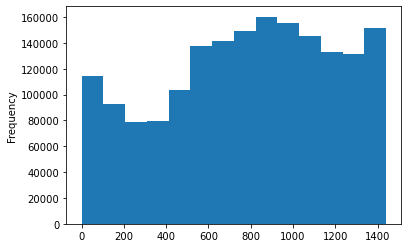

In [47]:
df[(df['minutes_active'] > 0) & (df['minutes_active'] < 1440)]['minutes_active'].plot.hist(bins=14)
#df['minutes_active'].plot.hist(bins=14)

### Item Domain ID - `category`
A qual domínio este item pertence. Temos mais de 8000 domínios diferentes representados no dataset.
O domínio diz o tipo do item, se é um fone de ouvido, uma capa de celular, uma camisa, etc.

O código do domínio depende do `site`, sendo os 3 primeiros caracteres de cada domínio o site em que ele está.

In [48]:
df['item_domain_id'].value_counts()

MLB-SUPPLEMENTS               786063
MLM-CELLPHONE_COVERS          592007
MLB-HAIR_TREATMENTS           266634
MLM-T_SHIRTS                  254175
MLM-HEADPHONES                247016
                               ...  
MLM-GAME_CONSOLE_MULTITAPS         7
MLA-MINI_BAG_SEALERS               6
MLA-GLOVES_AND_MITTENS             6
MLA-PET_FOOTWEAR                   5
MLA-RADIO_BASE_STATIONS            1
Name: item_domain_id, Length: 8408, dtype: int64

Vamos então observar quantos domínios temos independente de `site`. Vemos 3595 domínios presentes.

In [49]:
df['item_domain_id'].str.slice(start=4).value_counts()

SUPPLEMENTS                             963402
CELLPHONE_COVERS                        831405
SNEAKERS                                441054
HEADPHONES                              439547
T_SHIRTS                                397407
                                         ...  
EROTIC_PANTIES                              38
ELECTRIC_VEGETABLE_AND_FRUIT_PEELERS        30
CAMERA_SLIDERS                              27
SERVICE_CARTS                               15
GAME_CONSOLE_MULTITAPS                       7
Name: item_domain_id, Length: 3595, dtype: int64

Os dois domínios mais frequentes têm no mínimo 2x mais anúncios que os outros.

<AxesSubplot:>

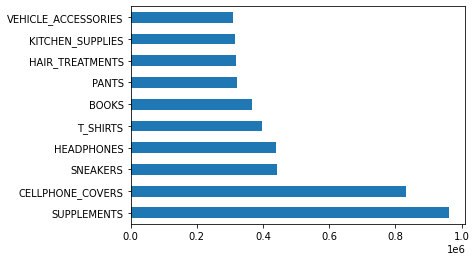

In [50]:
df['item_domain_id'].str.slice(start=4).value_counts()[:10].plot.barh()

### Item ID - `int64`
Identificador do item

In [51]:
df['item_id'].min(), df['item_id'].max(), df['item_id'].nunique()

(0, 517895, 517896)

### Item Title - `category`
Texto do título do anúncio. Os textos apresentam um tamanho variado, indo desde 2 caracteres até 170. Com a faixa mais comun sendo de 50-70 caracteres.

mean: 53.80782192293371
median: 57.0
min: 2
max: 169


<AxesSubplot:ylabel='Frequency'>

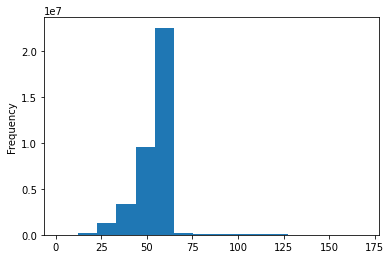

In [52]:
title_len = df['item_title'].str.len()
print('mean:', title_len.mean())
print('median:', title_len.median())
print('min:', title_len.min())
print('max:', title_len.max())
title_len.plot.hist(bins=16)

In [53]:
from nltk import download as nltk_download
nltk_download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Olhando para as palavras mais comuns entre os títulos, vemos que `kit` é a mais comum, possivelmete por ser uma palavra em inglês usada para todos os sites do MercadoLivre.

Além de `kit` vemos também algumas outras palavras em português e espanhol que aparecem entre as 50 mais comuns.

<AxesSubplot:>

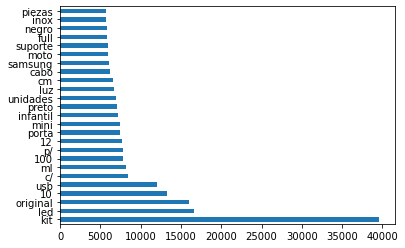

In [54]:
en = [unidecode(w.lower()) for w in stopwords.words('english')]
es = [unidecode(w.lower()) for w in stopwords.words('spanish')]
pt = [unidecode(w.lower()) for w in stopwords.words('portuguese')]
title_words = pd.Series(df['item_title'].unique()).str.lower().str.split().explode().str.strip()
title_words[~title_words.isin(en + es + pt) & (title_words.str.len() > 1)].value_counts()[:25].plot.barh()

### Site ID - `category`
Em qual MercadoLivre está anunciado. A grande maioria dos anúncios estão nos mercados brasileiro e argentino, uma vez que o MercadoLivre México é uma operação mais recente.

In [55]:
df['site_id'].value_counts()

MLB    19229164
MLM    15157936
MLA     3273179
Name: site_id, dtype: int64

In [56]:
df['site_id'].value_counts() / df['site_id'].count()

MLB    0.510595
MLM    0.402491
MLA    0.086913
Name: site_id, dtype: float64

### Product ID - `category` 
Qual é este produto. Temos mais de 15000 produtos diferentes. Os IDs de produto dependem do site, sendo os 3 primeiros caracteres identificadores do site.

Podemos observar que há um produto com muito mais registros do que os outros.

In [57]:
df['product_id'].nunique()

15863

<AxesSubplot:>

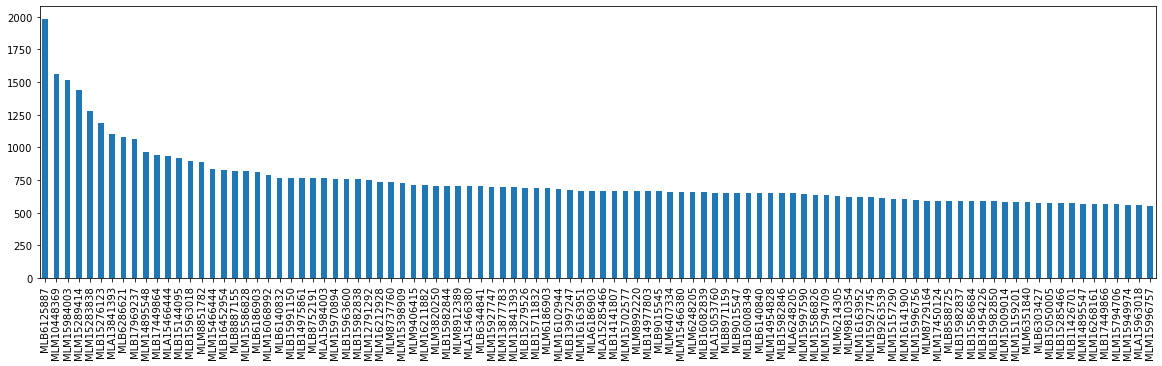

In [58]:
df['product_id'].value_counts()[:100].plot.bar(figsize=(20,5))

In [59]:
df[df['product_id'] == 'MLB6125887'].head()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,item_domain_id,item_id,item_title,site_id,product_id,product_family_id
3422527,264270,2021-02-01,0,189.0,REA,classic,drop_off,free_shipping,1440.0,MLB-INK_CARTRIDGES,180922,Kit 2 Cartuchos Hp 664 Preto E Color Impressor...,MLB,MLB6125887,MLB6125886
3422528,264270,2021-02-02,0,189.0,REA,classic,drop_off,free_shipping,1440.0,MLB-INK_CARTRIDGES,180922,Kit 2 Cartuchos Hp 664 Preto E Color Impressor...,MLB,MLB6125887,MLB6125886
3422529,264270,2021-02-03,0,189.0,REA,classic,drop_off,free_shipping,1440.0,MLB-INK_CARTRIDGES,180922,Kit 2 Cartuchos Hp 664 Preto E Color Impressor...,MLB,MLB6125887,MLB6125886
3422530,264270,2021-02-04,0,189.0,REA,classic,drop_off,free_shipping,1440.0,MLB-INK_CARTRIDGES,180922,Kit 2 Cartuchos Hp 664 Preto E Color Impressor...,MLB,MLB6125887,MLB6125886
3422531,264270,2021-02-05,0,189.0,REA,classic,drop_off,free_shipping,1440.0,MLB-INK_CARTRIDGES,180922,Kit 2 Cartuchos Hp 664 Preto E Color Impressor...,MLB,MLB6125887,MLB6125886


### Product Family ID - `category`
A qual família este produto pertence. Assim como o ID do produto, o ID da família do produto também depende o site. E também temos uma família muito mais representada que as outras.

In [60]:
df['product_family_id'].value_counts()[:10]

MLB12287867    14720
MLB12565471     8431
MLB15982834     7363
MLM15783673     5423
MLB13170701     5291
MLM14351008     5133
MLM15531951     5113
MLA14293885     5060
MLB16368722     4735
MLB10501956     4118
Name: product_family_id, dtype: int64

In [61]:
df[df['product_family_id'] == 'MLB12287867'].head()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,item_domain_id,item_id,item_title,site_id,product_id,product_family_id
26005,18836,2021-02-01,1,73.49,REA,classic,fulfillment,paid_shipping,1440.0,MLB-CARPETS,34255,"Tapete Sala Peludo Felpudo Luxo 1,00 X 1,50 Pr...",MLB,NaN,MLB12287867
26006,18836,2021-02-02,0,73.49,REA,classic,fulfillment,paid_shipping,1440.0,MLB-CARPETS,34255,"Tapete Sala Peludo Felpudo Luxo 1,00 X 1,50 Pr...",MLB,NaN,MLB12287867
26007,18836,2021-02-03,0,69.82,REA,classic,fulfillment,paid_shipping,1440.0,MLB-CARPETS,34255,"Tapete Sala Peludo Felpudo Luxo 1,00 X 1,50 Pr...",MLB,NaN,MLB12287867
26008,18836,2021-02-04,1,69.82,REA,classic,fulfillment,paid_shipping,1440.0,MLB-CARPETS,34255,"Tapete Sala Peludo Felpudo Luxo 1,00 X 1,50 Pr...",MLB,NaN,MLB12287867
26009,18836,2021-02-05,2,69.82,REA,classic,fulfillment,paid_shipping,1440.0,MLB-CARPETS,34255,"Tapete Sala Peludo Felpudo Luxo 1,00 X 1,50 Pr...",MLB,NaN,MLB12287867


## Análise Exploratória - Segunda Fase
Iniciando a segunda fase da análise, iremos olhar para mais de uma variável para tentar entender as possíveis relações entre cada atributo, para isto vamos usar algumas coisas que observamos na primeira fase da análise.

Nesta fase vamos observar relações par a par (onde fizer sentido), e então selecionaremos algumas relações específicas para aprofundarmos.

### Sold Quantity - `int64`
Vamos analisar a relação da quantidade de vendas com os outros atributos fornecidos

#### Currency - `category`
Vemos que a distribuição de vendas não varia tanto pelas moedas, inclusive no dólar com poucas amostras a distribuição permanece caudal.

Algo interessante de observar é a menor quantidade de vendas na moeda argentina mesmo que existam quase tantos anúncios no MLA quanto no MLB.

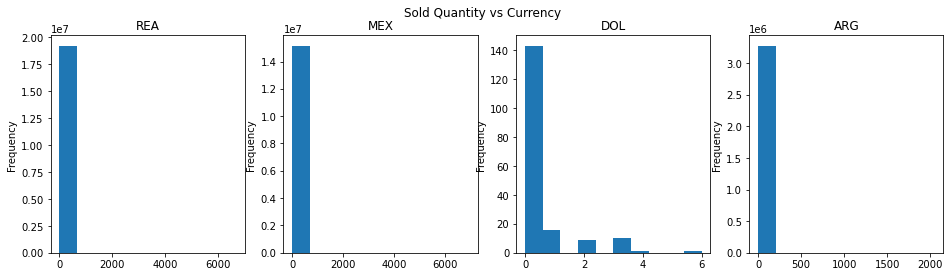

In [62]:
fig, axs = plt.subplots(1, 4, figsize=(16,4))
i = 0
for c in df['currency'].unique():
    axs[i].set_title(c)
    df[df['currency'] == c]['sold_quantity'].plot.hist(ax=axs[i])
    i += 1
fig.suptitle('Sold Quantity vs Currency')
plt.show()

#### Current Price - `float64`
Vendas por preço (e moeda). Vemos que não existe correlação direta entre o preço e a quantidade de vendas. Mesmo após a remoção de possíveis _outliers_ a correlação ainda não se manifesta.

In [63]:
for c in df['currency'].unique():
    filtered = df[df['currency'] == c]
    print(f'{c}:', filtered['current_price'].corr(filtered['sold_quantity']))

REA: -0.00011925828948753705
MEX: -0.00018246883597334066
DOL: -0.028946833196880555
ARG: -0.0013409781985491676


In [64]:
q1, q3 = df['current_price'].describe()[['25%', '75%']]
filtered = df[df['current_price'].between(q1 - 1.5 * (q3-q1), q3 + 1.5 * (q3-q1))]
for c in df['currency'].unique():
    print(f'{c}:', filtered.loc[filtered['currency'] == c, 'current_price'].corr(filtered['sold_quantity']))

REA: -0.01824146826821762
MEX: -0.023805291406054332
DOL: 0.007988461713294724
ARG: -0.0602806023840785


begin
REA
MEX
DOL
ARG


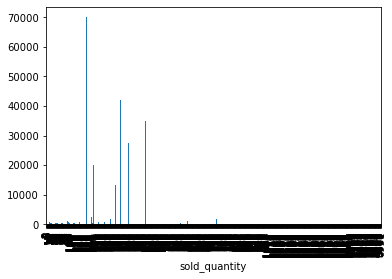

In [65]:
filtered = df.groupby(['sold_quantity', 'currency']).median()['current_price'].reset_index(level='currency')
print('begin')
for c in df['currency'].unique():
    print(c)
    filtered[filtered['currency'] == c]['current_price'].plot.bar()

#### Listing Type - `category`
Ao contrário do que era imaginado, anúncios clássicos têm mais vendas que anúncios premium. Dado que a quantidade de registros para cada um é uniformemente distribuída, vemos aqui uma diferenca considerável a favor dos anúncios clássicos. Com cerca de 1.15 vendas a cada anúncio clássico e 0.82 vendas por anúncio premium.

Possivelmente esta diferença é dada pelos itens ou pelos mercados nos quais eles se encontram.

<AxesSubplot:ylabel='listing_type'>

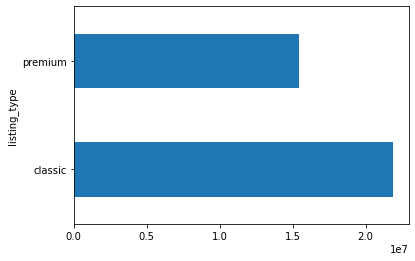

In [66]:
df.groupby('listing_type').sum()['sold_quantity'].plot.barh()

In [67]:
df.groupby('listing_type').sum()['sold_quantity'] / df['sold_quantity'].sum()

listing_type
classic    0.586195
premium    0.413805
Name: sold_quantity, dtype: float64

In [68]:
df.groupby('listing_type').sum()['sold_quantity'] / df['listing_type'].value_counts()

listing_type
classic    1.158886
premium    0.820750
dtype: float64

#### Shipping Logistic Type - `category`
Como temos muito mais anúncios com o tipo `fulfillment`, devemos realizar as análises considerando isto. E cosiderando isto, chegamos também a um impacto positivo do anúncio com tipo `fulfillment`, sendo 1.14 vendas a cada anúncio com este tipo de frete.

> Possivelmente esta diferença é dada pelos itens ou pelos mercados nos quais eles se encontram.

<AxesSubplot:>

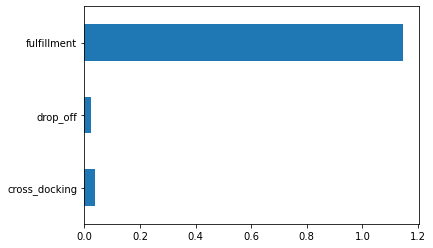

In [69]:
(df.groupby('shipping_logistic_type').sum()['sold_quantity'] / df['shipping_logistic_type'].value_counts()).plot.barh()

In [70]:
df.groupby('shipping_logistic_type').sum()['sold_quantity'] / df['shipping_logistic_type'].value_counts()

cross_docking    0.037044
drop_off         0.023740
fulfillment      1.146286
dtype: float64

#### Shipping Payment - `category`
Com os anúncios de frete pago pelo comprador tomando 2/3 dos registros, vemos que estes são responsáveis por 75% da quantidade de vendas.

In [71]:
df.groupby('shipping_payment').sum()['sold_quantity'] / df['sold_quantity'].sum()

shipping_payment
free_shipping    0.257118
paid_shipping    0.742882
Name: sold_quantity, dtype: float64

#### Minutes Active - `float64`
O esperado é que um anúncio que ficou mais tempo ativo levaria a mais vendas, mas a correlação direta não procede. Existem anúncios que não estão ativos durante o dia e ainda assim realizam vendas.

Porém ao observar um gráfico Minutos vs Vendas, podemos ver a correlação positiva entre minutos ativos e vendas.

In [72]:
filtered = df[df['sold_quantity'] > 0]
filtered['minutes_active'].corr(filtered['sold_quantity'])

0.0098686928386971

In [73]:
df[(df['minutes_active'] == 0) & (df['sold_quantity'] > 0)]['sold_quantity'].describe()

count    611.000000
mean       3.765957
std       10.077530
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max      153.000000
Name: sold_quantity, dtype: float64

<AxesSubplot:xlabel='minutes_active'>

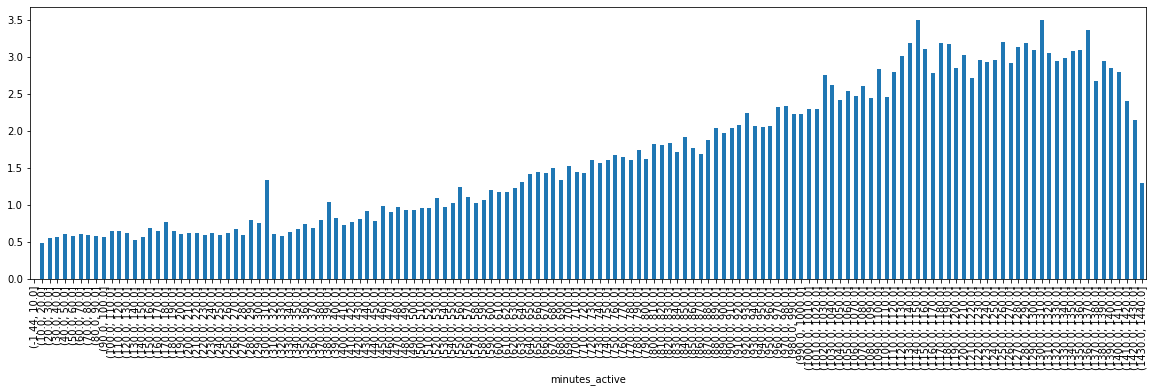

In [74]:
df.groupby(pd.cut(df['minutes_active'], 144))['sold_quantity'].mean().plot.bar(figsize=(20,5))

#### Item Domain ID - `category`
Máscaras cirúrgicas foi o domínio com mais vendas, tendo 3x mais vendas que o segundo domínio mais vendido de Suplemetos.

<AxesSubplot:xlabel='item_domain_id'>

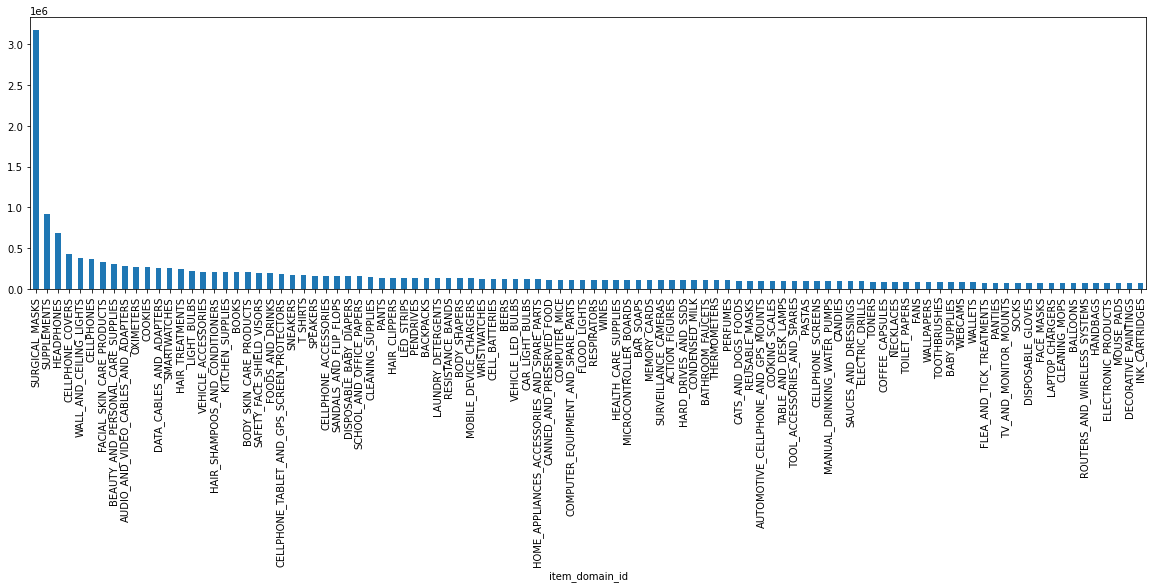

In [75]:
df.groupby(df['item_domain_id'].str.slice(start=4))['sold_quantity'].sum().nlargest(100).plot.bar(figsize=(20,5))

#### Item ID - `int64`
Existem itens com mais vendas do que outros, ou seja, o item carrega influência na quantidade de vendas.

<AxesSubplot:xlabel='item_id'>

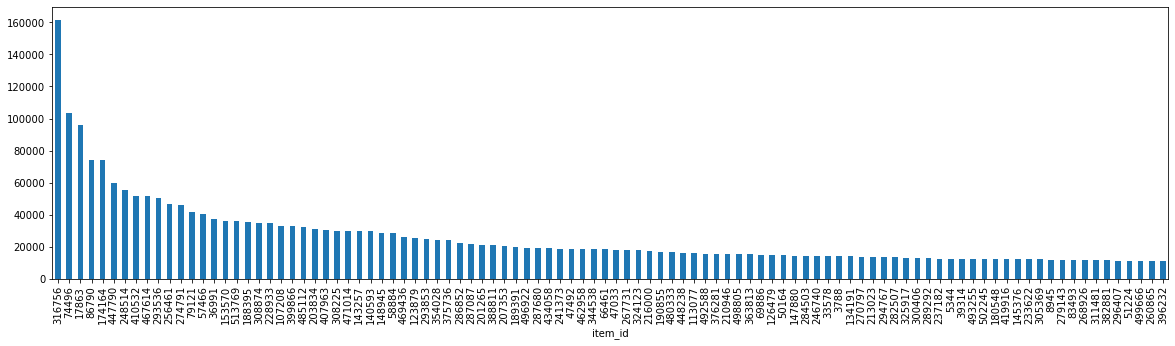

In [76]:
df.groupby('item_id')['sold_quantity'].sum().nlargest(100).plot.bar(figsize=(20,5))

#### Item Title - `category`
Ao analisar a relação entre a primeira palavra do anúncio e a quantidade de vendas, vemos que a palavra `Servico` apresenta mais de 80 vendas. O título do anúncio pode ser usado para entender a quantidade de vendas do mesmo.

<AxesSubplot:xlabel='item_title'>

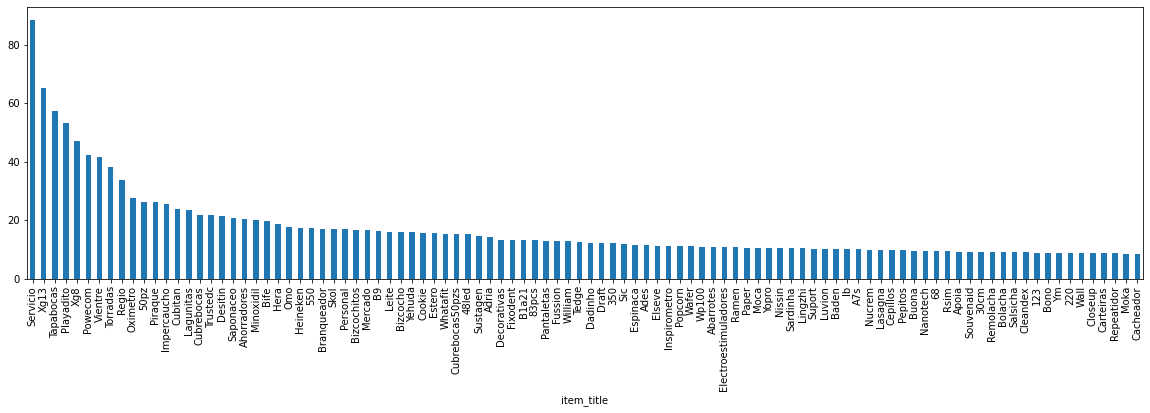

In [77]:
df.groupby(df['item_title'].str.extract(r'(\w+)', expand=False))['sold_quantity'].mean().nlargest(100).plot.bar(figsize=(20,5))

#### Site ID - `category`
Apesar de termos mais anúncios no MLA, vemos que o MLM tem uma quantidade de vendas por anúncio acima dos outros.

<AxesSubplot:xlabel='site_id'>

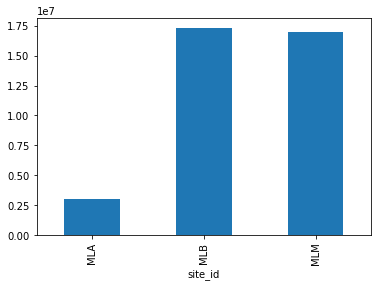

In [78]:
df.groupby('site_id')['sold_quantity'].sum().plot.bar()

In [79]:
for site in df['site_id'].unique():
    filtered = df[df['site_id'] == site]
    print(f'{site}:', filtered['sold_quantity'].sum() / filtered.shape[0])

MLB: 0.900091288420027
MLM: 1.1189863844259536
MLA: 0.9219370526329297


#### Product ID - `category`
Vemos também que existem produtos com muitas vendas

<AxesSubplot:xlabel='product_id'>

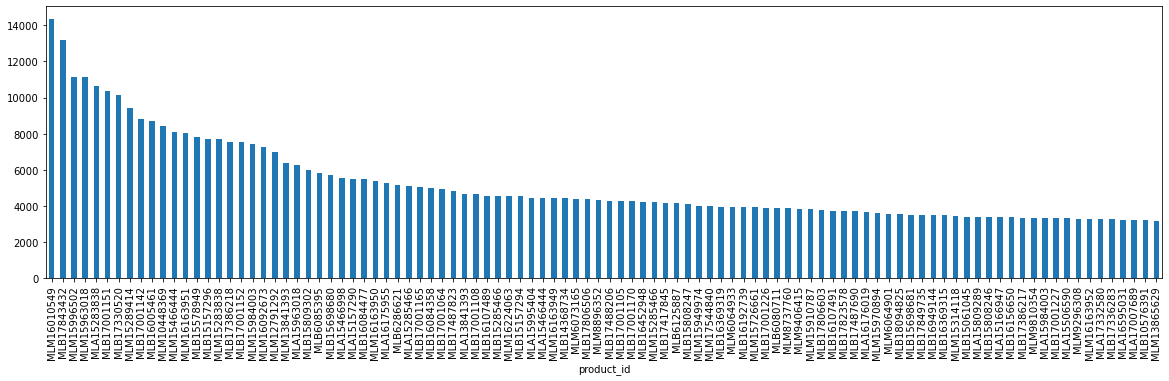

In [80]:
df.groupby('product_id')['sold_quantity'].sum().nlargest(100).plot.bar(figsize=(20,5))

#### Product Family ID - `category`
Há uma família de produtos com 4x mais vendas que as outras famílias.

<AxesSubplot:xlabel='product_family_id'>

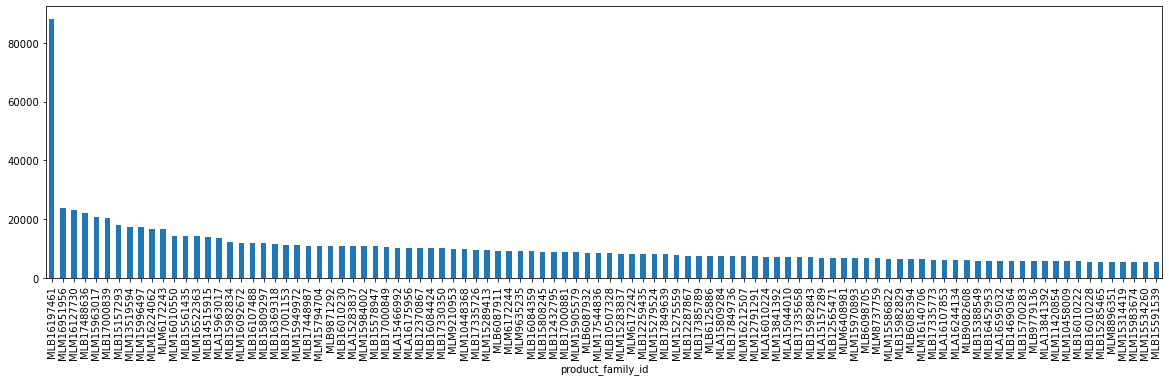

In [81]:
df.groupby('product_family_id')['sold_quantity'].sum().nlargest(100).plot.bar(figsize=(20,5))

### Current Price - `float64`
Vamos analisar a relação do preço com os outros atributos fornecidos

#### Listing Type - `category`
O esperado é que anúncios do tipo `premium` sejam mais caros. Isso acontece significativamente apenas nas moedas `ARG` e `MEX`

In [82]:
df.groupby(['currency', 'listing_type']).agg({'current_price': ['median', 'mean', 'count']})['current_price']

median          mean     count
currency listing_type                                 
ARG      classic       1490.00   3674.768313   3031240
         premium       4599.00  11622.125564    241939
DOL      classic         33.55    142.481667         6
         premium          4.80     13.168391       174
MEX      classic        205.00    639.391303   7298310
         premium        249.00   8151.467747   7859446
REA      classic         51.06    511.849883   8531293
         premium         55.68    163.067855  10697871

#### Shipping Logistic Type - `category`
Não aparenta existir relação significativa entre o tipo do envio e o preço do produto.

In [83]:
df.groupby(['currency', 'shipping_logistic_type']).agg({'current_price': ['median', 'mean', 'count']})['current_price']

median          mean     count
currency shipping_logistic_type                                 
ARG      cross_docking           2290.00   5737.046171    331996
         drop_off                2007.00  10375.490644    155488
         fulfillment             1510.50   3745.208814   2785695
DOL      cross_docking            687.14    687.140000         1
         drop_off                   3.20     12.800000         3
         fulfillment                4.80     13.753693       176
MEX      cross_docking            292.00  56554.757461    439914
         drop_off                 277.14  33189.362708   1145679
         fulfillment              225.00    429.475469  13572163
REA      cross_docking             53.96    675.672598   1732932
         drop_off                  49.98   2287.998863   1463771
         fulfillment               54.90     99.249838  16032461

#### Shipping Payment - `category`
Conforme o esperado, anúncios com frete pago pelo consumidor apresentam o preço mais baixo que anúncios com frete grátis ao consumidor.

In [84]:
df.groupby(['currency', 'shipping_payment']).agg({'current_price': ['median', 'mean', 'count']})['current_price']

median          mean     count
currency shipping_payment                                 
ARG      free_shipping     5499.00  10826.223129   1051859
         paid_shipping      980.00   1153.948960   2221320
DOL      free_shipping       33.77     44.364833        60
         paid_shipping        3.30      4.035833       120
MEX      free_shipping      529.00  10919.081986   6172701
         paid_shipping      139.00    148.276024   8985055
REA      free_shipping      159.00   1003.575538   5487904
         paid_shipping       39.90     43.932944  13741260

#### Item Domain ID - `category`
Em cada moeda pode-se observar que existem domínios mais caros que outros, isto é de se esperar, por exemplo, `MLA-ALL_IN_ONE` ser mais carro que `MLA-BICYCLES`.

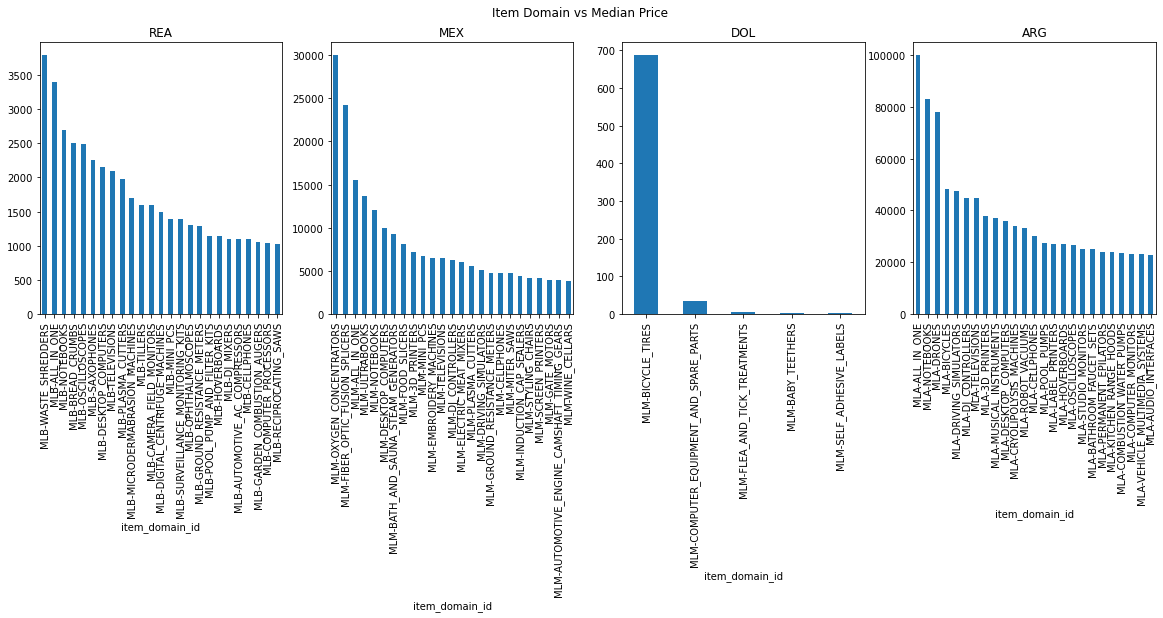

In [85]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for c in df['currency'].unique():
    grouped = df[df['currency'] == c].groupby('item_domain_id')['current_price'].median()
    axs[i].set_title(c)
    grouped.nlargest(25).plot.bar(ax=axs[i])
    i += 1
fig.suptitle('Item Domain vs Median Price')
plt.show()

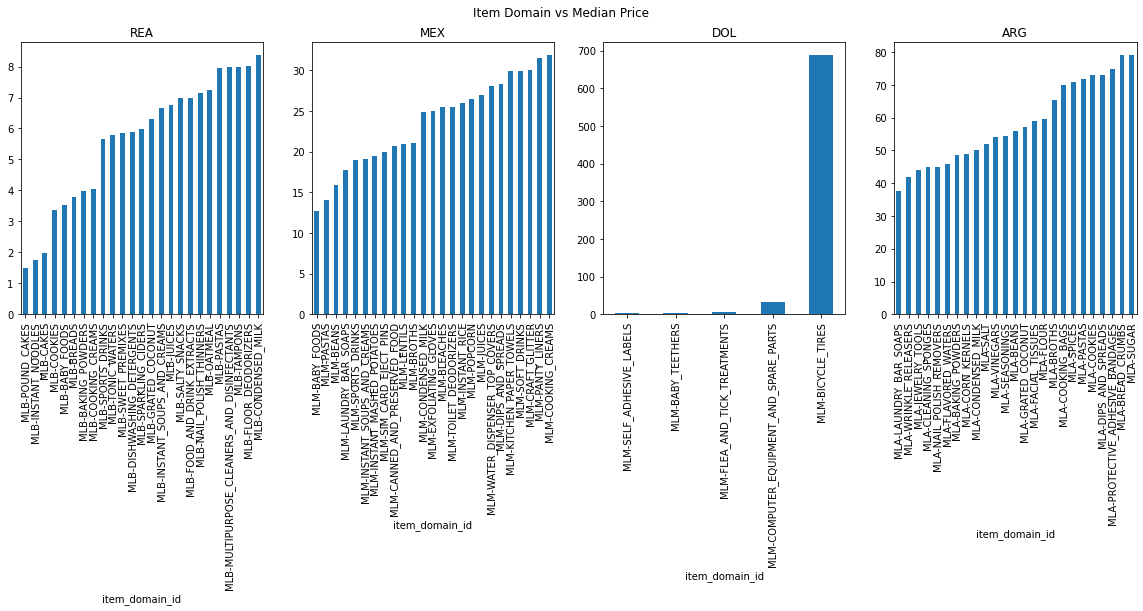

In [86]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for c in df['currency'].unique():
    grouped = df[df['currency'] == c].groupby('item_domain_id')['current_price'].median()
    axs[i].set_title(c)
    grouped.nsmallest(25).plot.bar(ax=axs[i])
    i += 1
fig.suptitle('Item Domain vs Median Price')
plt.show()

### Listing Type - `category`
Vamos analisar a relação do tipo do anúncio (`classic` ou `premium`) com os outros atributos

#### Shipping Logistic Type - `category`
Vemos uma distribuição igual para cada tipo de anúncio

<AxesSubplot:xlabel='listing_type,shipping_logistic_type'>

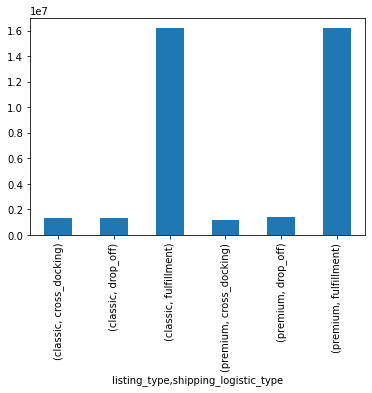

In [87]:
df.groupby(['listing_type', 'shipping_logistic_type'])['sku'].count().plot.bar()

#### Shipping Payment - `category`
Pode-se observar que anúncios `premium` tem uma proporção maior de fretes grátis ao consumidor.

<AxesSubplot:xlabel='listing_type,shipping_payment'>

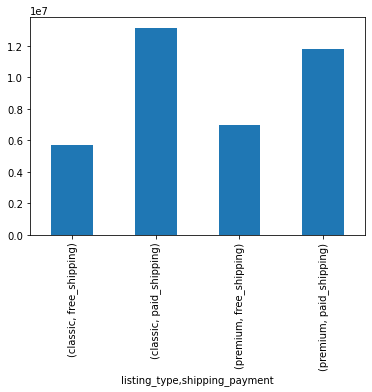

In [88]:
df.groupby(['listing_type', 'shipping_payment'])['sku'].count().plot.bar()

#### Minutes Active - `float64`
O tipo de anúncio não parece influenciar no tempo que ele fica ativo.

<AxesSubplot:ylabel='Frequency'>

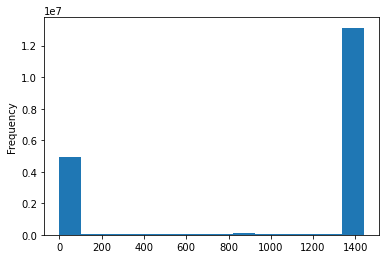

In [89]:
df[df['listing_type'] == 'classic']['minutes_active'].plot.hist(bins=14)

<AxesSubplot:ylabel='Frequency'>

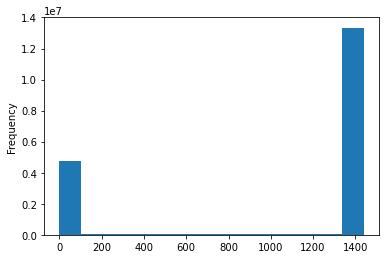

In [90]:
df[df['listing_type'] == 'premium']['minutes_active'].plot.hist(bins=14)

#### Item Domain ID - `category`
Para alguns domínios existem mais anuncios `premium`, e para outros mais anúncios `classic`.

<AxesSubplot:xlabel='item_domain_id,listing_type'>

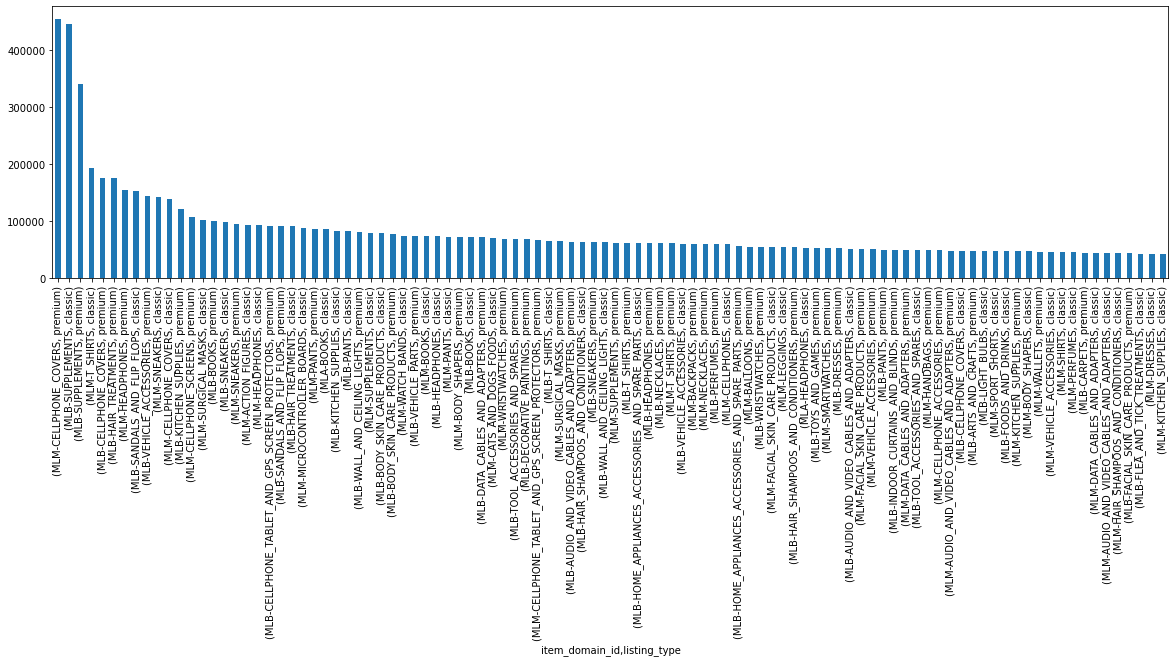

In [91]:
df.groupby(['item_domain_id', 'listing_type'])['sku'].count().nlargest(100).plot.bar(figsize=(20,5))

#### Site ID - `category`
O `MLA` atua como exceção com mais anúncios `classic` do que anúncios `premium`.

<AxesSubplot:xlabel='site_id,listing_type'>

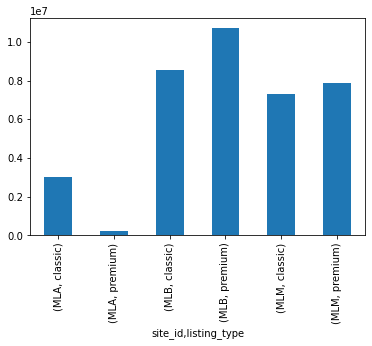

In [92]:
df.groupby(['site_id', 'listing_type'])['sku'].count().plot.bar()

### Shipping Logistic Type - `category`
Vamos analisar a relação do tipo de envio com os outros atributos

#### Shipping Payment - `category`
Não parece haver relação entre o tipo de envio e se o frete é pago pelo consumidor ou não. Com a proporção se mantendo independente do tipo do envio.

<AxesSubplot:xlabel='shipping_logistic_type,shipping_payment'>

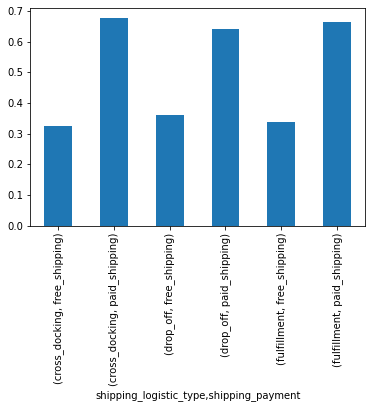

In [93]:
(df.groupby(['shipping_logistic_type', 'shipping_payment'])['sku'].count() / df.groupby('shipping_logistic_type')['sku'].count()).plot.bar()

#### Site ID - `category`
Também não observamos influência do site sobre o tipo de envio.

<AxesSubplot:xlabel='site_id,shipping_logistic_type'>

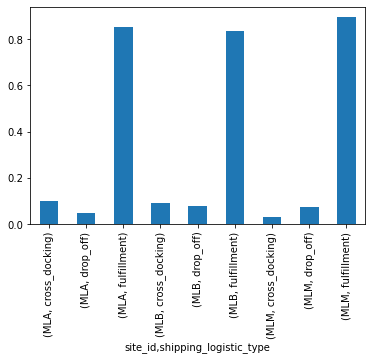

In [94]:
(df.groupby(['site_id', 'shipping_logistic_type'])['sku'].count() / df.groupby('site_id')['sku'].count()).plot.bar()

### Shipping Payment - `category`
Vamos analisar a relação do pagamento do envio com outros atributos

#### Site ID - `category`
Apeas no MLM existe uma proporção levemente maior de fretes grátis ao consumidor, mas ainda a maioria dos anúncios são de fretes pagos.

<AxesSubplot:xlabel='site_id,shipping_payment'>

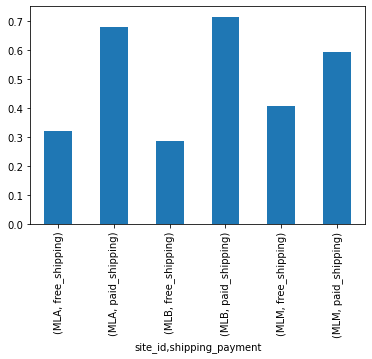

In [95]:
(df.groupby(['site_id', 'shipping_payment'])['sku'].count() / df.groupby('site_id')['sku'].count()).plot.bar()

### Minutes Active - `float64`
Vamos analisar os minutos ativos contra outros atributos

#### Site ID - `category`
O esperado é que não haja diferença para cada site, e isto é o que de fato acontece.

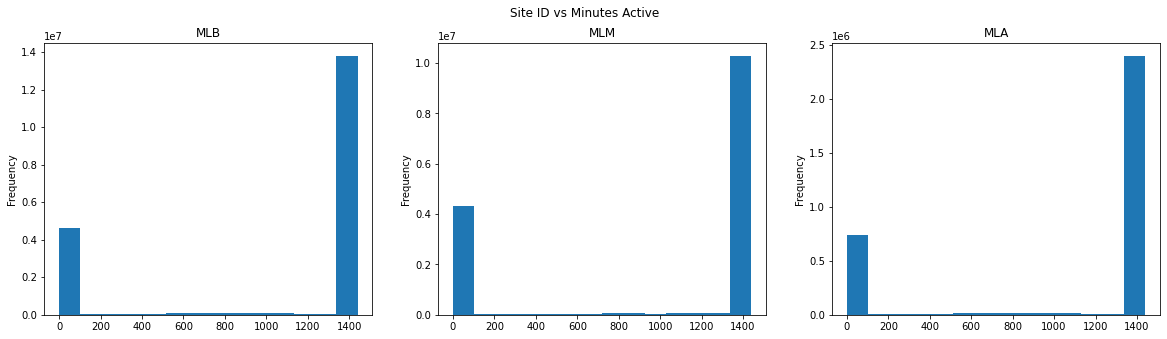

In [96]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
i = 0
for site in df['site_id'].unique():
    axs[i].set_title(site)
    df[df['site_id'] == site]['minutes_active'].plot.hist(bins=14, ax=axs[i])
    i += 1
fig.suptitle('Site ID vs Minutes Active')
plt.show()

## Análise Exploratória - Terceira Fase
Iniciando a terceira fase da análise, iremos olhar para mais de uma variável para melhor compreender as relações entre os atributos.

Nesta fase vamos observar relações não nos limitando a quantidade de variáveis.

### Sold Quantity x Site ID x Listing Type
A maior quantidade de vendas em anúncios `classic` se mantém independente do site do anúncio.

<AxesSubplot:ylabel='site_id,listing_type'>

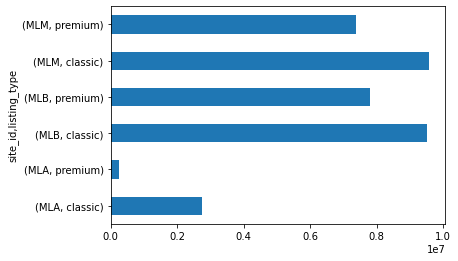

In [97]:
df.groupby(['site_id', 'listing_type'])['sold_quantity'].sum().plot.barh()

### Sold Quantity x Site ID x Shipping Logistic Type
O site não influencia na quantidade de vendas por tipo do envio.

<AxesSubplot:ylabel='site_id,shipping_logistic_type'>

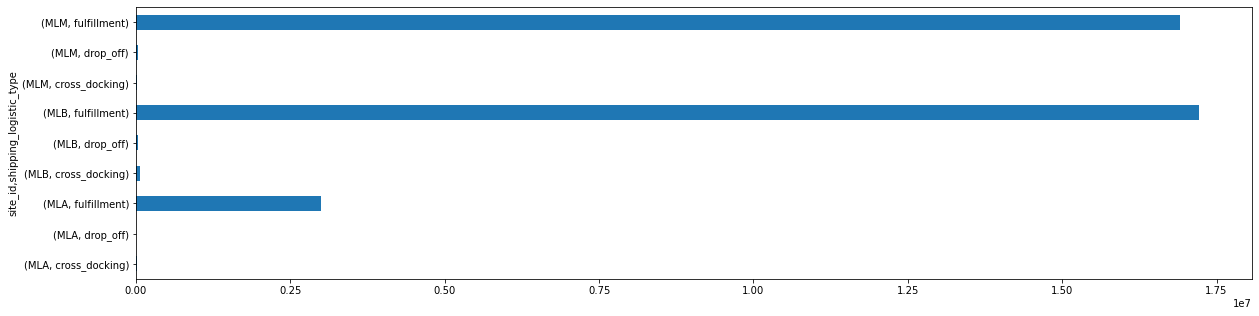

In [98]:
df.groupby(['site_id', 'shipping_logistic_type'])['sold_quantity'].sum().plot.barh(figsize=(20,5))

## Preparação dos DataFrames para o Modelo
Os dados que deverão ser consumidos pelo modelo vêm no formato (sku, target_stock), devemos preparar os dados de treinamento para atender a este formato.

Primeiramente, vamos separar os últimos 30 dias para validação.

In [24]:
# precisamos garantir que as entradas estão em ordem de sku e data
df.sort_values(['sku', 'date'], inplace=True)


In [25]:
cutoff_date = (df['date'].max() - pd.Timedelta(days=30))
df_train = df.loc[df['date'] <= cutoff_date]
df_validation = df.loc[df['date'] > cutoff_date]
df_train['date'].nunique(), df_validation['date'].nunique()

(29, 30)

Agora, temos que gerar os valores de estoque para montar o conjunto da mesma forma que vem o conjunto de testes. Com duas colunas (sku, target_stock)

In [26]:
def transform(df):
    df_new = pd.DataFrame()
    df_new['sold_quantity'] = df.groupby('sku')['sold_quantity'].apply(np.array)
    def find_min_day(sales):
        valid = sales.nonzero()[0]
        return valid[0] if valid.size > 0 else 1
    first = df_new['sold_quantity'].apply(find_min_day)
    last = np.full(df_new.shape[0], 31)
    df_new['days'] = np.random.randint(first, last)
    df_new[df_new['days'] > 30]['days'] = 30
    df_new[df_new['days'] < 1]['days'] = 1
    df_new['target_stock'] = df_new.apply(lambda x: np.sum(x['sold_quantity'][:x['days']]), axis=1)
    return df_new.drop(columns='sold_quantity')


Vamos transformar cada `DataFrame` para o formato necessário.

In [27]:
df_train_new = transform(df_train)
df_validation_new = transform(df_validation)

<ipython-input-26-9124de78b801>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[df_new['days'] < 1]['days'] = 1
<ipython-input-26-9124de78b801>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[df_new['days'] < 1]['days'] = 1


In [28]:
train = df_train.merge(df_train_new, how='left', on='sku')
validation = df_validation.merge(df_validation_new, how='left', on='sku')

In [29]:
del df_train, df_validation, df_train_new, df_validation_new
gc.collect()

15

## Definição da métrica de avaliação
Usaremos RPS como métrica, por ser a métrica utilizada no desafio.

In [30]:
def rps(clf, X, y):
    y = np.array(y, dtype=np.int64)
    y_pred = clf.predict_proba(X)
    y_one_hot = np.zeros_like(y_pred)
    y_one_hot[np.arange(y.shape[0]), y-1] = 1

    return ((y_one_hot.cumsum(axis=1) - y_pred.cumsum(axis=1))**2).sum(axis=1).mean()

def evaluate(clf, df):
    return rps(clf, pd.get_dummies(df, columns=dummy_columns)[x_columns], validation[y_column])

## Modelo Baseline
Agora que finalizamos as etapas da análise exploratória, vamos preparar um modelo básico para responder ao problema e então iterar sobre este.

Este modelo baseado em árvore obteve um score de `6.03`.

Para treinar o modelo, vamos utilizar apenas as colunas numéricas e as colunas categóricas de baixa cardinalidade. O modelo baseline será uma árvore de decisão, que deverá classificar entre 30 classes (0 a 29).

In [106]:
dummy_columns = ['currency', 'listing_type', 'shipping_logistic_type', 'shipping_payment', 'site_id']
new_train = pd.get_dummies(train, columns=dummy_columns)
x_columns = new_train.columns.drop(['sku', 'date', 'item_domain_id', 'item_id', 'item_title', 'product_id', 'product_family_id', 'days', 'target_stock'])
y_column = 'days'
clf = DecisionTreeClassifier()
clf.fit(new_train[x_columns], new_train[y_column] - 1)

Wall time: 2min 18s


DecisionTreeClassifier()

In [109]:
evaluate(clf, validation)

6.032857158224656

## Modelo v2